In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Load the data

In [77]:
datafile = 'data/vowel-context.data'

# Column names obtained from data/vowel-context.names
colnames = [
    'Test',
    'Speaker number',
    'Sex',
    'Feature 0',
    'Feature 1',
    'Feature 2',
    'Feature 3',
    'Feature 4',
    'Feature 5',
    'Feature 6',
    'Feature 7',
    'Feature 8',
    'Feature 9',
    'Class'
]

df = pd.read_csv(datafile, delimiter='\s+', names=colnames)

In [78]:
df.head()

Test  Speaker number  Sex  Feature 0  Feature 1  Feature 2  Feature 3  \
0     0               0    0     -3.639      0.418     -0.670      1.779   
1     0               0    0     -3.327      0.496     -0.694      1.365   
2     0               0    0     -2.120      0.894     -1.576      0.147   
3     0               0    0     -2.287      1.809     -1.498      1.012   
4     0               0    0     -2.598      1.938     -0.846      1.062   

   Feature 4  Feature 5  Feature 6  Feature 7  Feature 8  Feature 9  Class  
0     -0.168      1.627     -0.388      0.529     -0.874     -0.814      0  
1     -0.265      1.933     -0.363      0.510     -0.621     -0.488      1  
2     -0.707      1.559     -0.579      0.676     -0.809     -0.049      2  
3     -1.053      1.060     -0.567      0.235     -0.091     -0.795      3  
4     -1.633      0.764      0.394     -0.150      0.277     -0.396      4

I think there may be more categorical variables here that need to be scrubbed. "Speaker number" is probably not numerical, but it's treated as such. It should be included as a series of one-hot vectors or dropped, depending on the purpose of this model.

In [79]:
df['Speaker number'].describe()

count    990.000000
mean       7.000000
std        4.322678
min        0.000000
25%        3.000000
50%        7.000000
75%       11.000000
max       14.000000
Name: Speaker number, dtype: float64

In [80]:
xcols = df.columns[3:-1]
ycols = df.columns[-1:]

# Split into training, testing

For now use the values in the dataset

In [81]:
inds = np.arange(df.shape[0])
np.random.seed(3)
np.random.shuffle(inds)

In [82]:
train_len = int(np.round(0.7 * df.shape[0]))
test_len = df.shape[0] - train_len

In [83]:
assert train_len + test_len == df.shape[0]

In [84]:
train = df.loc[inds[:train_len]]
test = df.loc[inds[train_len:]]

In [85]:
assert train.shape[0] == train_len
assert test.shape[0] == test_len

# Create the estimator

In [86]:
svc = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC())
])

In [87]:
parameters = [
    {
        'svc__kernel': ['rbf'],
        'svc__C': np.logspace(-3, 3),
        'svc__gamma': np.logspace(-2, 1)
    },{
        'svc__kernel': ['linear'],
        'svc__C': np.logspace(-3, 3)
    }
]

In [88]:
gs = GridSearchCV(svc, param_grid=parameters, cv=5)

In [89]:
gs.fit(train[xcols], train[ycols].values.ravel())

/Users/jrpowers-luhn/miniconda3/envs/cs528/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'svc__kernel': ['rbf'], 'svc__C': array([1.00000e-03, 1.32571e-03, 1.75751e-03, 2.32995e-03, 3.08884e-03,
       4.09492e-03, 5.42868e-03, 7.19686e-03, 9.54095e-03, 1.26486e-02,
       1.67683e-02, 2.22300e-02, 2.94705e-02, 3.90694e-02, 5.17947e-02,
       6.86649e-02, 9.10298e-02, 1.20...1.84207e+02, 2.44205e+02,
       3.23746e+02, 4.29193e+02, 5.68987e+02, 7.54312e+02, 1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [90]:
gs.score(train[xcols], train[ycols].values.ravel())

1.0

In [91]:
gs.score(test[xcols], test[ycols].values.ravel())

0.9932659932659933

In [92]:
gs.best_params_

{'svc__C': 10.985411419875572,
 'svc__gamma': 0.16768329368110083,
 'svc__kernel': 'rbf'}

Training confusion

Text(0.5, 1.0, 'Training data')

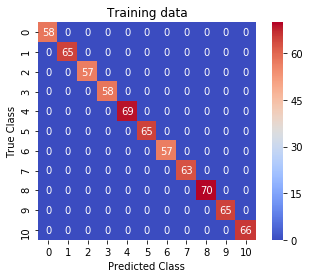

In [93]:
sns.heatmap(confusion_matrix(gs.predict(train[xcols]), train[ycols]), cmap='coolwarm', square=True, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Training data')

In [94]:
gs.best_params_

{'svc__C': 10.985411419875572,
 'svc__gamma': 0.16768329368110083,
 'svc__kernel': 'rbf'}

Fine grid search

In [96]:
coarse_C = gs.best_params_['svc__C']
coarse_gamma = gs.best_params_['svc__gamma']

In [97]:
fine_parameters = {
    'svc__C': np.linspace(coarse_C * 0.9, coarse_C * 1.1),
    'svc__gamma': np.linspace(coarse_gamma * 0.9, coarse_gamma * 1.1)
}

In [98]:
gs = GridSearchCV(svc, param_grid=fine_parameters, cv=5)
gs.fit(train[xcols], train[ycols].values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'svc__C': array([ 9.88687,  9.93171,  9.97655, 10.02139, 10.06622, 10.11106,
       10.1559 , 10.20074, 10.24558, 10.29042, 10.33525, 10.38009,
       10.42493, 10.46977, 10.51461, 10.55945, 10.60428, 10.64912,
       10.69396, 10.7388 , 10.78364, 10.82848, 10.87332, 10.91815,
       10....29, 0.17898,
       0.17966, 0.18035, 0.18103, 0.18171, 0.1824 , 0.18308, 0.18377,
       0.18445])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [99]:
gs.best_params_

{'svc__C': 10.514608073309477, 'svc__gamma': 0.1762385637668713}

Text(0.5, 1.0, 'Training data')

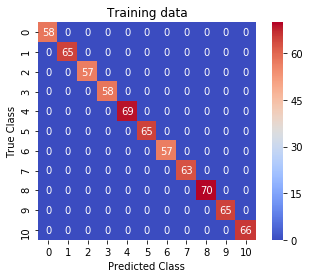

In [100]:
sns.heatmap(confusion_matrix(gs.predict(train[xcols]), train[ycols]), cmap='coolwarm', square=True, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Training data')

Text(0.5, 1.0, 'Test data')

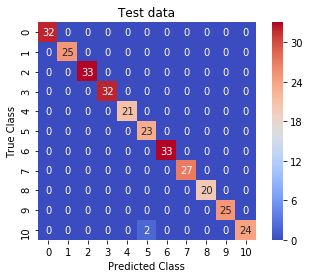

In [101]:
sns.heatmap(confusion_matrix(gs.predict(test[xcols]), test[ycols].values.ravel()), cmap='coolwarm', square=True, annot=True)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Test data')

In [102]:
print(classification_report(gs.predict(train[xcols]), train[ycols].values.ravel()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        65
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        58
           4       1.00      1.00      1.00        69
           5       1.00      1.00      1.00        65
           6       1.00      1.00      1.00        57
           7       1.00      1.00      1.00        63
           8       1.00      1.00      1.00        70
           9       1.00      1.00      1.00        65
          10       1.00      1.00      1.00        66

   micro avg       1.00      1.00      1.00       693
   macro avg       1.00      1.00      1.00       693
weighted avg       1.00      1.00      1.00       693



In [103]:
print(classification_report(gs.predict(test[xcols]), test[ycols].values.ravel()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        33
           3       1.00      1.00      1.00        32
           4       1.00      1.00      1.00        21
           5       0.92      1.00      0.96        23
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        27
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00        25
          10       1.00      0.92      0.96        26

   micro avg       0.99      0.99      0.99       297
   macro avg       0.99      0.99      0.99       297
weighted avg       0.99      0.99      0.99       297



In [104]:
gs.score(test[xcols], test[ycols].values.ravel())

0.9932659932659933